### importing libraries and modules

In [1]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt
from forward_config import device, Pk, t_end, L
from model import DNN


### train model

In [2]:
import matplotlib.cm as cm
import time
from torch.optim.lr_scheduler import ExponentialLR


device = torch.device(device)

lr = 0.001
epochs = 35000

u = torch.linspace(0, 1, 50)
t = torch.linspace(0, 1, 50)
###
grid = torch.cartesian_prod(u,t).float().to(device)

# p(u,0)=1
bnd1 = torch.cartesian_prod(u, torch.tensor([0.])).float().to(device)
bndval1 = torch.tensor([1.]).to(device)

#bnd2(u(-1), t)=1
bnd2 = torch.cartesian_prod(torch.tensor([1.]), t).float().to(device)
bndval2 = torch.tensor([1.]).to(device)

#bnd3
bnd3 = torch.cartesian_prod(torch.tensor([0.]), t).float().to(device)

NN = torch.nn.Sequential(
            torch.nn.Linear(2, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 100),
            torch.nn.Tanh(),
            torch.nn.Linear(100, 1))


# Initialize neural network
model = DNN(NN).to(device)


# Loss and optimizer
optimizer = torch.optim.Adam(model.net.parameters(), lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

    # Train PINNs
for epoch in range(epochs):
    model.train()

    def closure():
        optimizer.zero_grad()
        loss_pde = model.loss_pde(grid)
        loss_bnd1 = model.loss_dirichlet(bnd1, bndval1).reshape(-1)
        loss_bnd2 = model.loss_dirichlet(bnd2, bndval2).reshape(-1)
        loss_bnd3 = model.loss_operator(bnd3).reshape(-1)

        loss = 10*loss_pde + 1000*loss_bnd1.mean() + 100*(torch.hstack([loss_bnd2, loss_bnd3])).mean()

        loss.backward()
        return loss


    # Optimize loss function
    loss_pde = optimizer.step(closure)

    loss_value = loss_pde.item() if not isinstance(loss_pde, float) else loss_pde


    if epoch%3000 == 0:
        scheduler.step()

    if epoch%1500==0:
        print(f'epoch {epoch}: loss {loss_value:.6f}')


epoch 0: loss 1327.336426
epoch 1500: loss 0.017024
epoch 3000: loss 0.012080
epoch 4500: loss 0.021688
epoch 6000: loss 0.022132
epoch 7500: loss 0.006644
epoch 9000: loss 0.004966
epoch 10500: loss 0.004569
epoch 12000: loss 0.020757
epoch 13500: loss 0.008538
epoch 15000: loss 0.005691
epoch 16500: loss 0.003300
epoch 18000: loss 0.002328
epoch 19500: loss 0.002313
epoch 21000: loss 0.001888
epoch 22500: loss 0.001564
epoch 24000: loss 0.001469
epoch 25500: loss 0.006220
epoch 27000: loss 0.004585
epoch 28500: loss 0.002674
epoch 30000: loss 0.002195
epoch 31500: loss 0.001385
epoch 33000: loss 0.001564
epoch 34500: loss 0.002244


### compare with finite diffs

tensor(86400.)


<Figure size 640x480 with 0 Axes>

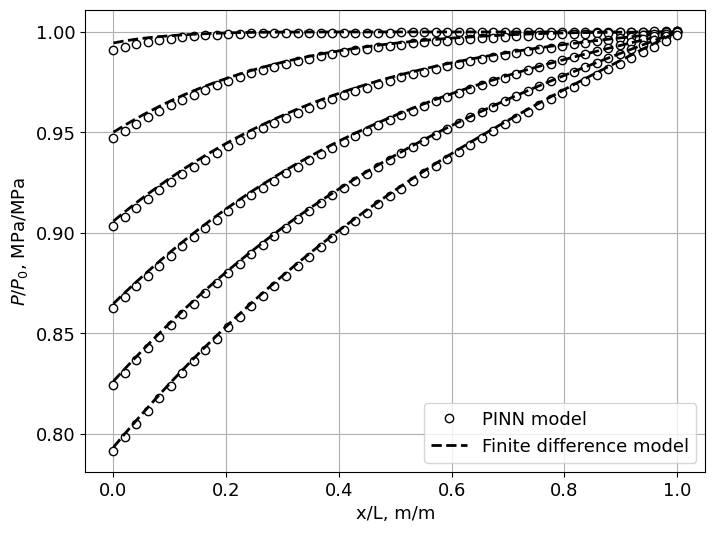

In [3]:
from reference import finite_diffs

P, x, t = finite_diffs(50, 50)

u = torch.linspace(0, 1, 50)
t = torch.linspace(0, 1, 50)

grid1 = torch.cartesian_prod(u, torch.tensor([t[1].item()])).float().to(device)
grid2 = torch.cartesian_prod(u, torch.tensor([t[10].item()])).float().to(device)
grid3 = torch.cartesian_prod(u, torch.tensor([t[20].item()])).float().to(device)
grid4 = torch.cartesian_prod(u, torch.tensor([t[30].item()])).float().to(device)
grid5 = torch.cartesian_prod(u, torch.tensor([t[40].item()])).float().to(device)
grid6 = torch.cartesian_prod(u, torch.tensor([t[49].item()])).float().to(device)
print(t[49]*t_end)

import matplotlib
plt.figure()
plt.figure(figsize=(8, 6))
font = {'serif' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

plt.plot(u, model(grid1).cpu().detach().numpy(),'o', c='k', mfc='w', mec='k',ms=6, label = 'PINN model')
plt.plot(u, P[:,1]/Pk, '--', c='k', lw=2, label = 'Finite difference model')
plt.plot(u, model(grid2).cpu().detach().numpy(),'o', c='k', mfc='w', mec='k',ms=6)
plt.plot(u, P[:,10]/Pk, '--', c='k', lw=2)
plt.plot(u, model(grid3).cpu().detach().numpy(), 'o', c='k', mfc='w', mec='k',ms=6)
plt.plot(u, P[:,20]/Pk, '--', c='k', lw=2)
plt.plot(u, model(grid4).cpu().detach().numpy(), 'o', c='k', mfc='w', mec='k',ms=6)
plt.plot(u, P[:,30]/Pk, '--', c='k', lw=2)
plt.plot(u, model(grid5).cpu().detach().numpy(), 'o', c='k', mfc='w', mec='k',ms=6)
plt.plot(u, P[:,40]/Pk, '--', c='k', lw=2)
plt.plot(u, model(grid6).cpu().detach().numpy(), 'o', c='k', mfc='w', mec='k',ms=6)
plt.plot(u, P[:,49]/Pk, '--', c='k', lw=2)
plt.xlabel('x/L, m/m')
plt.ylabel('$P/P_0$, MPa/MPa')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('PINN_FD.pdf',dpi = 1000)


<Figure size 640x480 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

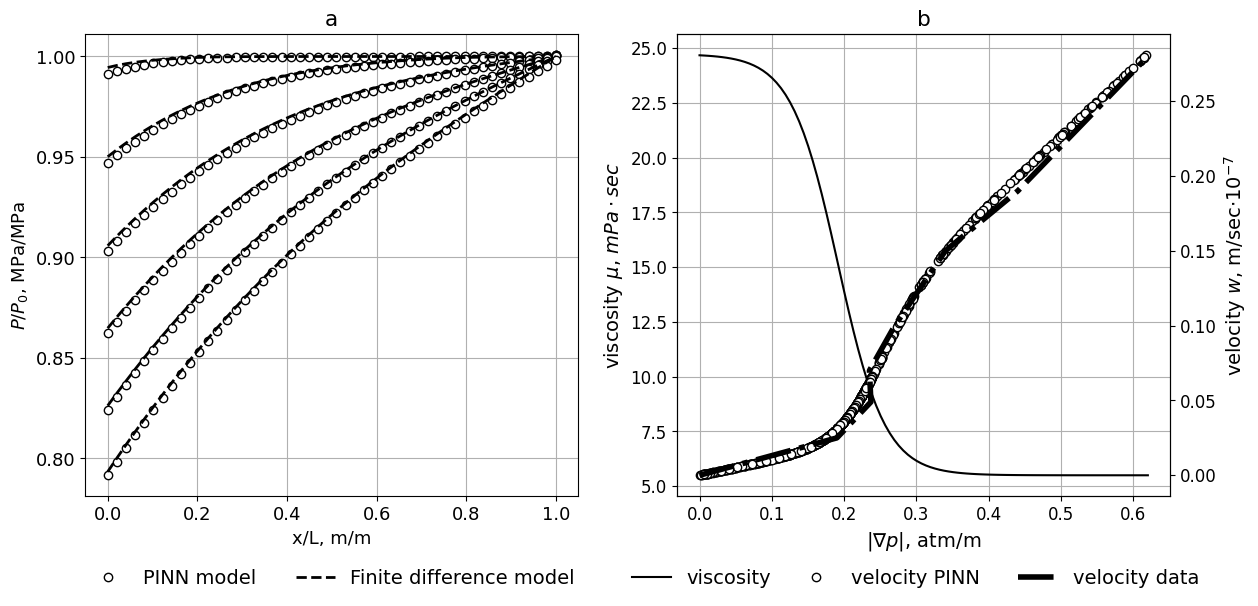

In [4]:
from numpy import genfromtxt

dp_grad = genfromtxt('for_plot/dp_grad.csv')
f = genfromtxt('for_plot/f.csv')
grad_mu = genfromtxt('for_plot/grad_mu.csv')
gradient = genfromtxt('for_plot/gradient.csv')
model_velocity = genfromtxt('for_plot/model_velocity.csv')
mu_oil = genfromtxt('for_plot/mu_oil.csv')

import matplotlib
plt.figure()
plt.figure(figsize=(14, 8))
font = {'serif' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(u, model(grid1).cpu().detach().numpy(),'o', c='k', mfc='w', mec='k',ms=6, label = 'PINN model')
ax1.plot(u, P[:,1]/Pk, '--', c='k', lw=2, label = 'Finite difference model')
ax1.plot(u, model(grid2).cpu().detach().numpy(),'o', c='k', mfc='w', mec='k',ms=6)
ax1.plot(u, P[:,10]/Pk, '--', c='k', lw=2)
ax1.plot(u, model(grid3).cpu().detach().numpy(), 'o', c='k', mfc='w', mec='k',ms=6)
ax1.plot(u, P[:,20]/Pk, '--', c='k', lw=2)
ax1.plot(u, model(grid4).cpu().detach().numpy(), 'o', c='k', mfc='w', mec='k',ms=6)
ax1.plot(u, P[:,30]/Pk, '--', c='k', lw=2)
ax1.plot(u, model(grid5).cpu().detach().numpy(), 'o', c='k', mfc='w', mec='k',ms=6)
ax1.plot(u, P[:,40]/Pk, '--', c='k', lw=2)
ax1.plot(u, model(grid6).cpu().detach().numpy(), 'o', c='k', mfc='w', mec='k',ms=6)
ax1.plot(u, P[:,49]/Pk, '--', c='k', lw=2)
ax1.set_xlabel('x/L, m/m')
ax1.set_ylabel('$P/P_0$, MPa/MPa')
ax1.set_title('a')
ax1.grid()
ax1.legend(loc='upper center', fontsize=14, frameon=False, bbox_to_anchor=(0.5, -0.12), ncol=2)

ax2.plot(grad_mu, mu_oil, c='k', mfc='w', mec='k',ms=6, label='viscosity')
ax2_sec = ax2.twinx ()
ax2_sec.plot(dp_grad, model_velocity, 'o', c='k', mfc='w', mec='k',ms=6, label = 'velocity PINN')
ax2_sec.plot(gradient, f, '-.', c='k', lw=4, label = 'velocity data')
ax2.grid()
ax2.set_xlabel(r'$|\nabla p|$, atm/m', fontsize=14)
ax2.set_ylabel('viscosity $\mu$, $mPa\cdot sec$', fontsize=14)
ax2_sec.set_ylabel('velocity $w$, m/sec$\cdot 10^{-7}$', fontsize=14)
ax2.legend(loc='upper center', fontsize=14, frameon=False, bbox_to_anchor=(0.05, -0.12), ncol=1)
ax2_sec.legend(loc='upper center', fontsize=14, frameon=False, bbox_to_anchor=(0.65, -0.12), ncol=2)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2_sec.tick_params(axis='both', which='major', labelsize=12)
ax2.set_title('b')
# plt.savefig('baikov_double.eps',dpi = 1000, bbox_inches='tight')
plt.show()

### relative rmse confidence bound

In [ ]:
def fd_solution(grid):
    """Interpolate finite difference solution to another grid"""
    P, x, t = finite_diffs(300, 200)

    P = (P / Pk).reshape(-1)

    x = x / L

    t = t / t_end

    grid_fd = torch.cartesian_prod(torch.from_numpy(x), torch.from_numpy(t))

    u = scipy.interpolate.griddata(grid_fd, P, grid, method='nearest')

    return u

rel_rmse = []

for i in range(10):

    device = torch.device(device)

    lr = 0.001
    epochs = 35000

    u = torch.linspace(0, 1, 50)
    t = torch.linspace(0, 1, 50)
    ###
    grid = torch.cartesian_prod(u,t).float().to(device)

    # p(u,0)=1
    bnd1 = torch.cartesian_prod(u, torch.tensor([0.])).float().to(device)
    bndval1 = torch.tensor([1.]).to(device)

    #bnd2(u(-1), t)=1
    bnd2 = torch.cartesian_prod(torch.tensor([1.]), t).float().to(device)
    bndval2 = torch.tensor([1.]).to(device)

    #bnd3
    bnd3 = torch.cartesian_prod(torch.tensor([0.]), t).float().to(device)

    NN = torch.nn.Sequential(
                torch.nn.Linear(2, 50),
                torch.nn.Tanh(),
                torch.nn.Linear(50, 50),
                torch.nn.Tanh(),
                torch.nn.Linear(50, 50),
                torch.nn.Tanh(),
                torch.nn.Linear(50, 50),
                torch.nn.Tanh(),
                torch.nn.Linear(50, 50),
                torch.nn.Tanh(),
                torch.nn.Linear(50, 50),
                torch.nn.Tanh(),
                torch.nn.Linear(50, 50),
                torch.nn.Tanh(),
                torch.nn.Linear(50, 50),
                torch.nn.Tanh(),
                torch.nn.Linear(50, 1))


    # Initialize neural network
    model = DNN(NN).to(device)


    # Loss and optimizer
    optimizer = torch.optim.Adam(model.net.parameters(), lr)
    scheduler = ExponentialLR(optimizer, gamma=0.9)

        # Train PINNs
    for epoch in range(epochs):
        model.train()

        def closure():
            optimizer.zero_grad()
            loss_pde = model.loss_pde(grid)
            loss_bnd1 = model.loss_dirichlet(bnd1, bndval1).reshape(-1)
            loss_bnd2 = model.loss_dirichlet(bnd2, bndval2).reshape(-1)
            loss_bnd3 = model.loss_operator(bnd3).reshape(-1)

            loss = 10*loss_pde + 1000*loss_bnd1.mean() + 100*(torch.hstack([loss_bnd2, loss_bnd3])).mean()

            loss.backward()
            return loss


        # Optimize loss function
        loss_pde = optimizer.step(closure)


        if epoch%3000 == 0:
            scheduler.step()

    pinn_sol = model(grid).detach().cpu().numpy().reshape(-1)

    fd_sol, xx, tt = finite_diffs(50, 50)

    fd_sol = (fd_sol / Pk).reshape(-1)

    rmse = np.sqrt(np.sum((fd_sol - pinn_sol)**2)) / np.sqrt(np.sum(fd_sol**2))
    print("relative RMSE= ", rmse)
    rel_rmse.append(rmse)

In [ ]:
import scipy.stats as st 
 
# create 95% confidence interval 
conf_inerval = st.t.interval(confidence=0.95, df=len(rel_rmse)-1, 
                            loc=np.mean(rel_rmse), 
                            scale=st.sem(rel_rmse))

conf_inerval

(0.0010860691378432965, 0.0016176330561918318)

## Heat map

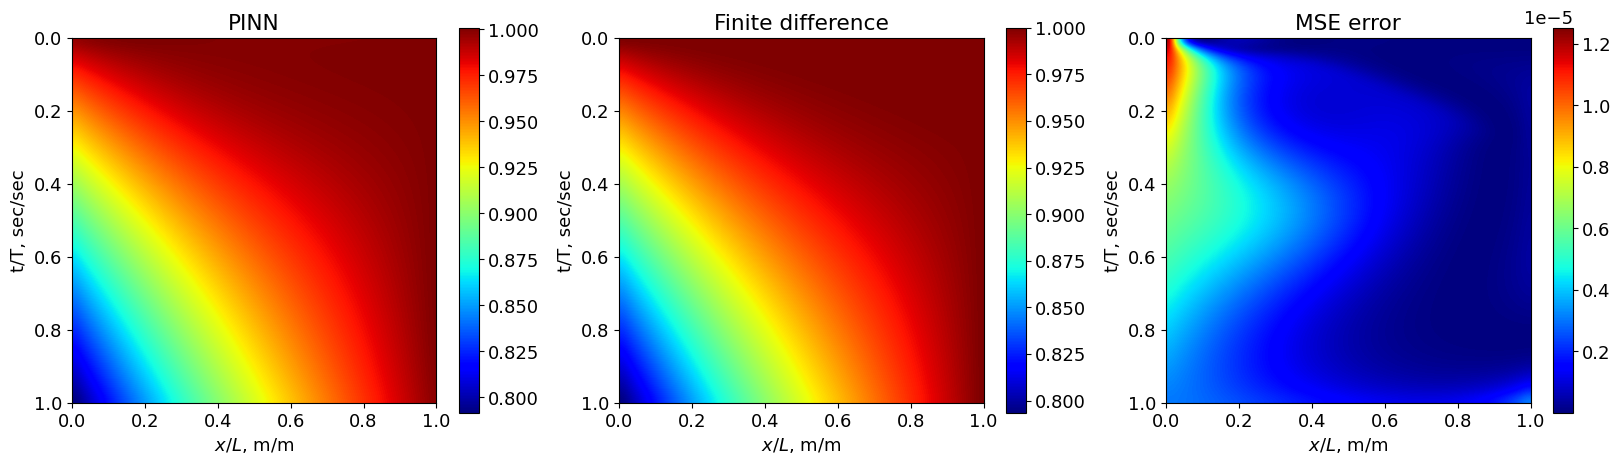

In [43]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

u = torch.linspace(0, 1, 50)
t = torch.linspace(0, 1, 50)
###
grid = torch.cartesian_prod(u,t).float().to(device)

nn_sol = model(grid).detach().cpu().reshape(50, 50).T

fd_sol = finite_diffs(50, 50)[0].reshape(50,50).T/Pk

mse_error = (nn_sol-fd_sol)**2

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(20, 5))
im0 = ax0.imshow(nn_sol, cmap=cm.jet,  interpolation='bicubic', extent=[0, 1, 1, 0])
fig.colorbar(im0, ax=ax0)
ax0.set_title('PINN')
ax0.set_ylabel('t/T, sec/sec')
ax0.set_xlabel('$x/L$, m/m')

im1 = ax1.imshow(fd_sol, cmap=cm.jet, interpolation='bicubic', extent=[0, 1, 1, 0])
fig.colorbar(im1, ax=ax1)
ax1.set_title('Finite difference')
ax1.set_ylabel('t/T, sec/sec')
ax1.set_xlabel('$x/L$, m/m')

im2 = ax2.imshow(mse_error, cmap=cm.jet, interpolation='bicubic', extent=[0, 1, 1, 0])
fig.colorbar(im2, ax=ax2)
ax2.set_title('MSE error')
ax2.set_ylabel('t/T, sec/sec')
ax2.set_xlabel('$x/L$, m/m')
# plt.savefig('baikov_triple.eps')
plt.show()